# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

### Florian Mohnert, Mario Giulianelli, Akash Raj

In [1]:
import copy
import itertools
import math
import pickle
import random
import time

from collections import defaultdict
from IPython.display import Image
from math import log, exp
from matplotlib import pyplot as plt
from pprint import pprint
from scipy.stats import binom_test

import numpy as np

import gensim
import pyndri
import pyndri.compat

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [2]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)
            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [3]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [4]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [5]:
example_document = index.document(index.document_base())
# print(example_document)

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [6]:
token2id, id2token, _ = index.get_dictionary()
# print(list(id2token.items())[:15])

Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [7]:
# print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [8]:
# query_tokens = index.tokenize("University of Massachusetts")
# print("Query by tokens:", query_tokens)
# query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
# print("Query by ids with stopwords:", query_id_tokens)
# query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
# print("Query by ids without stopwords:", query_id_tokens)

Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [9]:
# matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
# print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
# print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [10]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

# with open('./ap_88_89/topics_title', 'r') as f_topics:
#     print(parse_topics([f_topics]))

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [11]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)
term2numdocs = collections.defaultdict(int)
total_terms = 0

start_time = time.time()

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())
    
    for word in list(document_bow.keys()):
        
        term2numdocs[word]+=1

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 78.59462881088257 seconds.


## Lexical retrieval methods

In [12]:
def IDF(query_term_id):
    """
    Inverse Document Frequency of a query term.
    
    :param query_token_id: the query term id 
    """
    df = len(list(inverted_index[query_term_id]))
                       
    return log(num_documents / df)     

In [13]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    TF-IDF scoring function for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    return document_term_freq * IDF(query_term_id)

In [14]:
def BM25(int_document_id, query_term_id, document_term_freq, k1=1.2, b=0.75):
    """
    BM25 scoring function for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    :param k1: defines how fast belief saturates
    :param b: controls the level of normalization
    """
    tf = document_term_freq
    idf = IDF(query_term_id)
    doc_len = document_lengths[int_doc_id]

    return (k1 + 1) * tf / (k1 * ((1 - b) + b * (doc_len / avg_doc_length)) + tf) * idf

In [15]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, **kwargs):
    """
    Retrieval language model with Jelinek-Mercer smoothing.
    Returns the LM score for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param l: the interpolation parameter
    """
    l = kwargs["lambda"]
    
    d = document_lengths[int_doc_id]
    document_score = document_term_freq / d
    collection_score =  collection_frequencies[query_term_id] / total_terms
        
    return l * document_score + (1 - l) * collection_score

In [16]:
def dirichlet_prior(int_document_id, query_term_id, document_term_freq, **kwargs): 
    """
    Retrieval language model with Dirichlet prior smoothing.
    Returns the LM score for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    :mu: hyperparameter
    """
    mu = kwargs["mu"]
    
    collection_freq_w = collection_frequencies[query_term_id]
    collection_prior = collection_freq_w / total_terms
    d = document_lengths[int_document_id]
    
    score = (document_term_freq + mu * collection_prior) / (d + mu)
    
    return score

In [17]:
def absolute_discounting(int_document_id, query_term_id, document_term_freq, **kwargs):
    """
    Retrieval language model with Absolute Discounting smoothing.
    Returns the LM score for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    :param delta: hyperparameter
    """
    delta = kwargs["delta"]
    
    collection_freq_w = collection_frequencies[query_term_id]
    collection_prior = collection_freq_w / total_terms
    
    d = document_lengths[int_document_id]
    unique_words = unique_terms_per_document[int_document_id]
    
    score = (max(document_term_freq - delta, 0) / d) + (delta * unique_words / d) * collection_prior
    
    return score

### Positional Language Model

In [18]:
# Kernel functions for Positional Language Model

def passage_kernel(i, j, sigma=50):
    """
    Non-proximity based Passage kernel (baseline)

    :param i: position
    :param j: position
    :param sigma: hyperparameter
    """
    proximity = abs(i - j)

    return 1 if proximity <= sigma else 0

def gaussian_kernel(i, j, sigma=50):
    proximity = abs(i - j)

    return np.exp(-proximity ** 2 / (2 * sigma ** 2))

def triangle_kernel(i, j, sigma=50):
    proximity = abs(i - j)

    if proximity > sigma:
        return 0

    return (1 - proximity / sigma)

def hamming_kernel(i, j, sigma=50):
    """
    Cosine kernel

    :param i: position
    :param j: position
    :param sigma: hyperparameter
    """
    proximity = abs(i - j)
    
    if proximity > sigma:
        return 0
    
    return 0.5 * (1 + np.cos(proximity * np.pi / sigma))

def circle_kernel(i, j, sigma=50):
    proximity = abs(i - j)
    
    if proximity > sigma:
        return 0
    
    return np.sqrt(1 - (proximity / sigma) ** 2)


# Sanity Test cases
assert passage_kernel(0, 0), 0
assert gaussian_kernel(0, 0), 1
assert triangle_kernel(0 ,0), 0
assert hamming_kernel(0, 0), 0
assert circle_kernel(0, 0), 0

In [19]:
# This takes about 5 minutes to run. Read from the binary file collection_freq_all

def collection_freq_all():
    """
    General collection Language model (collection term frequency)

    Return: a dictionary containing P(w | C) values
    """
    glm = defaultdict(lambda:0)

    for doc_id in np.arange(index.document_base(), index.maximum_document()):
        document = index.document(doc_id)
        for word in document[1]:
            glm[word] += 1

    return glm


collection_freq_all = collection_freq_all()

with open('collection_freq_all', 'wb+') as f:
    pickle.dump(dict(collection_freq_all), f, protocol=pickle.HIGHEST_PROTOCOL)

# The code above takes about 5 minutes to run. Read from the binary file general_lm instead.
with open('collection_freq_all', 'rb') as f:
    collection_freq_all = pickle.load(f)

In [20]:
def doc_word_pos_util(Q, D):
    """
    Returns a dictionary with the position of each occurence of word 'w' in Document 'D'
    
    :param Q: list of query terms
    :param D: Document
    """
    resp = {}

    for i, w in enumerate(D):
        if w not in resp.keys():
            resp[w] = [i]
        else:
            resp[w].append(i)

    return resp

def plm_model_smoothed(i, w, D, doc_length, mu=500):
    """
    P(w|D, i))

    :param i: position
    :param w: word
    :param D: dictionary containing the positions where w occurs
    :param doc_length: Number of terms in the document
    :param mu: for smoothing

    Return: np array of length 5 containing the scores for each kernel
    """
    plm = np.zeros(5)

    if w in D:
        for j in D[w]:
            plm[0] += passage_kernel(i, j)
            plm[1] += gaussian_kernel(i, j)
            plm[2] += triangle_kernel(i, j)
            plm[3] += hamming_kernel(i, j)
            plm[4] += circle_kernel(i, j)

    plm += (mu * collection_freq_all[w])  # collection LM is used as the background model

    plm[0] /= (sum([passage_kernel(i, j) for j in range(1, doc_length + 1)]) + mu)
    plm[1] /= (sum([gaussian_kernel(i, j) for j in range(1, doc_length + 1)]) + mu)
    plm[2] /= (sum([triangle_kernel(i, j) for j in range(1, doc_length + 1)]) + mu)
    plm[3] /= (sum([hamming_kernel(i, j) for j in range(1, doc_length + 1)]) + mu)
    plm[4] /= (sum([circle_kernel(i, j) for j in range(1, doc_length + 1)]) + mu)

    return plm

def plm_score(i, Q, D, mu=500):
    """
    Score each PLM using Kullback-Leibler divergence retrieval model

    :param i: position
    :param Q: list of query terms
    :param D: Document
    """
    # Query likelihood model - 1 / query length
    query_lm = 1.0 / len(Q)

    # Kullback-Leibler divergence retrieval model
    kl_divergence = np.zeros(5)

    resp = doc_word_pos_util(Q, D[1])

    for w in Q:
        if w in D[1]:
            plm = plm_model_smoothed(i, w, resp, len(D[1]), mu)
            for k in range(5):
                kl_divergence[k] += (- query_lm * math.log(query_lm / plm[k]))

    return kl_divergence

def best_position_strategy(Q, D, mu=500):
    """
    Score a document based on the score of its best matching position.
    S(Q, D) = max_i {S(Q, D, i)}
    
    :param Q: list of query terms
    :param D: Document
    :mu: hyperparameter
    
    Return: A list containing the score for each kernel
    """
    # Initialize KL-D for all the 5 kernels
    max_score = [-99999999] * 5

    for i in range(1, len(D) + 1):
        scores = plm_score(i, Q, D, mu)

        for k in range(5):
            if max_score[k] < scores[k]:
                max_score[k] = scores[k]

    return max_score

> Now some utility functions and convenient data structures...

In [21]:
# Define, for convenience, a dictionary mapping external
# document ids to internal document document ids. 

ext_to_int = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, _ = index.document(int_doc_id)
    ext_to_int[ext_doc_id] = int_doc_id

In [22]:
# Read TREC ground truth file containing the VALIDATION SET.
# Create dictionary validation_ids that maps queries to internal and external docID pairs.
# validation_ids: queryID --> (internal_doc_id, external_doc_id)

with open("ap_88_89/qrel_validation", "r") as f:
    validation_ids = {}
    
    for line in f:
        line = line.strip().split()
        if len(line) != 4:
            continue
            
        q_id = line[0]
        ext_id = line[2]
        
        try:
            int_id = ext_to_int[ext_id]
            
            try:
                validation_ids[q_id].append((int_id, ext_id))
            except KeyError:
                validation_ids[q_id] = [(int_id, ext_id)]
            
        except KeyError:
            pass  # validation document not in index

In [23]:
# Read TREC ground truth file containing the TEST SET.
# Create dictionary test_ids that maps queries to internal and external docID pairs.
# test_ids: queryID --> (internal_doc_id, external_doc_id)

with open("ap_88_89/qrel_test","r") as f:
    test_ids = {}
    
    for line in f:
        line = line.strip().split()
        if len(line) != 4:
            continue
            
        q_id = line[0]
        ext_id = line[2]
        
        try:
            int_id = ext_to_int[ext_id]
        
            try:
                test_ids[q_id].append((int_id, ext_id))
            except KeyError:
                test_ids[q_id] = [(int_id, ext_id)]
                
        except KeyError:
            pass  # test document not in index
                 

In [24]:
def run_retrieval(model_name, score_fn, **kwargs):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example)
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        print("This output file ({}) already exists.\n".format(run_out_path),
              "Delete this file, rename it, or move it elsewhere in your file system.\n", sep='')
        return
    
    try:
        dataset = kwargs.pop('dataset')
    except KeyError:
        # use test set if user does not express a preference
        dataset = 'test'
    
    if dataset == 'test':
        query_to_docs = test_ids
    elif dataset == 'validation':
        query_to_docs = validation_ids
    else:
        raise ValueError("Two possible values for dataset: 'test' or 'validation'.")
    
    data = {}

    print('Retrieval model: {}'.format(model_name))
    
    # Fill the data dictionary. 
    # The dictionary data has the form: query_id --> (document_score, external_doc_id)
    cnt = 0
    
    # FOR ALL QUERIES
    for query_id in query_to_docs.keys():  
        # FOR ALL DOCUMENTS
        for int_doc_id, ext_doc_id in query_to_docs[query_id]:  
                
            # discard all zero length docs
            if document_lengths[int_doc_id] == 0:
                try:
                    data[query_id].append((0.0, ext_doc_id))
                except:
                    data[query_id] = [(0.0, ext_doc_id)]
                continue
                    
            score = 0
            cnt_qwords_in_doc = 0  # how many query words occ
 
            # FOR ALL QUERY TERMS
            for q_term in tokenized_queries[query_id]: 
                try: 
                    document_term_freq = inverted_index[q_term][int_doc_id]
                    cnt_qwords_in_doc += 1
                except KeyError:
                    document_term_freq = 0  # query term is not in the document

                if model_name == "tfidf" or model_name == "BM25":
                    score += score_fn(int_doc_id, q_term, document_term_freq, **kwargs)
                else:
                    score += log(score_fn(int_doc_id, q_term, document_term_freq, **kwargs))

            # only score documents that contain at least one query term
            if cnt_qwords_in_doc == 0:
                try:
                    data[query_id].append((0.0, ext_doc_id))
                except:
                    data[query_id] = [(0.0, ext_doc_id)]
                continue

            # transform back from log-probs to probs
            if model_name != "tfidf" and model_name != "BM25": 
                score = exp(score)
            
            # Fill data dictionary
            try:
                data[query_id].append((score, ext_doc_id))
            except:
                data[query_id] = [(score, ext_doc_id)]
    
    # Write output to TREC .run file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)  # only consider top 1000 docs for each query

In [25]:
def simulation_plm(kernel, k_id, mu, data_set='validation'):
    """
    Generate run files for various kernels and mus
    
    :param kernel: the type of kernel - [passage, gaussian, triangle, hamming, circle]
    :param k_id: id for the kernel type
    :param mu: hyperparam
    :param data_set: specify validation or test dataset
    """
    print('PLM for kernel: {0} and mu: {1}'.format(kernel, str(mu)))
    data = {}
    
    if data_set == 'validation':
        query_to_docs = validation_ids
    else:
        query_to_docs = test_ids

    for query_id in query_to_docs.keys():
        doc_scores = []

        for int_doc_id, ext_doc_id in query_to_docs[query_id]:

            doc = index.document(int_doc_id)
            query_terms = tokenized_queries[query_id]
            scores = best_position_strategy(query_terms, doc, mu=mu)
            doc_scores.append((scores[k_id], ext_doc_id))  # Store only values for required kernel

        doc_scores = list(reversed(sorted(doc_scores, key=lambda tup: tup[1])))

        # Remove documents where query terms do not occur
        doc_with_terms = []
        for item in doc_scores:
            if item[0] < 0:
                doc_with_terms.append(item)
            elif item[0] == 0:
                doc_with_terms.append((-999999, item[1]))

        data[query_id] = doc_with_terms

    with open('runs/plm/plm_{0}_{1}_{2}.run'.format(kernel, str(mu), data_set), 'w') as f_out:
        write_run(
            model_name='plm_{0}_{1}'.format(kernel, str(mu)),
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

> ... now we are ready to retrieve documents using all the methods defined so far.

### Hyperparameter optimization

In [26]:
# Run all retrieval methods for all the VALIDATION queries and write the TREC-friendly results to a file. 

run_retrieval('tfidf', tfidf, **{"dataset":'validation'})
run_retrieval('BM25', BM25, **{"dataset":'validation'})

run_retrieval('jelinek_mercer_0.1', jelinek_mercer, **{"dataset":'validation', "lambda":0.1})
run_retrieval('jelinek_mercer_0.5', jelinek_mercer, **{"dataset":'validation', "lambda":0.5})
run_retrieval('jelinek_mercer_0.9', jelinek_mercer, **{"dataset":'validation', "lambda":0.9})

run_retrieval('dirichlet_prior_500', dirichlet_prior, **{"dataset":'validation', "mu":500})
run_retrieval('dirichlet_prior_1000', dirichlet_prior, **{"dataset":'validation', "mu":1000})
run_retrieval('dirichlet_prior_1500', dirichlet_prior, **{"dataset":'validation', "mu":1500})

run_retrieval('absolute_discounting_0.1', absolute_discounting, **{"dataset":'validation', "delta":0.1})
run_retrieval('absolute_discounting_0.5', absolute_discounting, **{"dataset":'validation', "delta":0.5})
run_retrieval('absolute_discounting_0.9', absolute_discounting, **{"dataset":'validation', "delta":0.9})

Retrieval model: tfidf
Retrieval model: BM25
Retrieval model: jelinek_mercer_0.1
Retrieval model: jelinek_mercer_0.5
Retrieval model: jelinek_mercer_0.9
Retrieval model: dirichlet_prior_500
Retrieval model: dirichlet_prior_1000
Retrieval model: dirichlet_prior_1500
Retrieval model: absolute_discounting_0.1
Retrieval model: absolute_discounting_0.5
Retrieval model: absolute_discounting_0.9


In [ ]:
#PLM

mus = [500, 1000, 1500]
kernel = {
    'passage': 0,
    'gaussian': 1,
    'triangle': 2,
    'hamming': 3,
    'circle': 4
}

for k in kernel.keys():
    for mu in mus:
        simulation_plm(kernel=k, k_id=kernel[k], mu=mu, data_set='test')

#### PLM, nDCG@10

|                  | mu: 500    | mu: 1000   | mu: 1500   |
|------------------|:----------:|:----------:|:----------:|
|Passage           | 0.2712     | 0.2759     | 0.2773     |
|Gaussian          | 0.2565     | 0.2565     | 0.2605     |
|Triangle          | 0.2422     | 0.2454     | 0.2467     |
|Hamming           | 0.2436     | 0.2405     | 0.2407     |
|Circle            | 0.2492     | 0.2512     | 0.2525     |

> a few more utility functions for plotting...

In [28]:
#### Plotting NDCG@10 for different hyperparamaters ####

def read_statistics(filepath):
    """
    Read statistics from TREC_EVAL output file and store them in an array.
    """
    data = []

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip().split('\t')

            if len(line) != 3:
                continue

            data.append(float(line[2]))

    return data[:-1]


def plot_ndcg_stats(data, labels):
    """
    Print NDCG@10 statistics for multiple hyperparameter values.
    """
    fig, ax = plt.subplots()
    colors = ['red', 'green', 'blue']
    data = [[list(range(len(x))), x] for x in data]

    for ndcg, color in zip(data, colors):
        x, y = ndcg
        label = labels[colors.index(color)]
        ax.scatter(x, y, c=color, label=label, alpha=0.3, edgecolors='none')
        ax.set_xlabel('queries')
        ax.set_ylabel('NDCG@10')

    ax.legend()
    ax.grid(True)

In [29]:
def plot_ndcg_stats(data, labels):
    '''
    Print NDCG@10 statistics for multiple hyperparameter values.
    '''
    fig, ax = plt.subplots()
    colors = ['red', 'green', 'blue',"brown","yellow","cyan"]
    data = [[list(range(len(x))), x] for x in data]
    scale = [150,120,90,90,70,50]
    for ndcg, color in zip(data, colors):
        x, y = ndcg
        label = labels[colors.index(color)]
        ax.scatter(x, y, c=color, label=label, alpha=0.4, edgecolors='none', s = scale[colors.index(color)])
        minor_ticks = np.arange(0,31,1)
        ax.set_xticks(minor_ticks)
        ax.set_xlabel('queries')
        ax.set_ylabel('NDCG@10')

    ax.legend()
    ax.grid(True)
    ax.grid(axis = "x", which='minor', linestyle=":")


### NDCG@10 with varying hyperparameter values

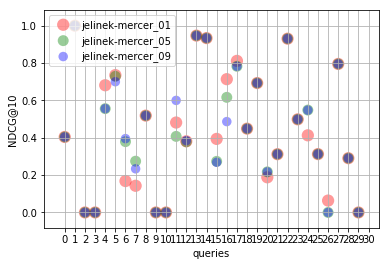

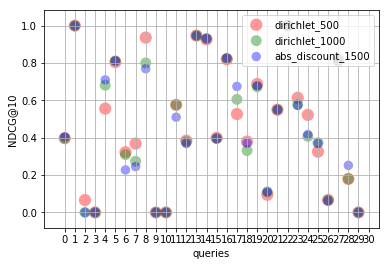

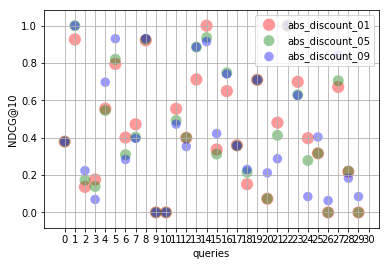

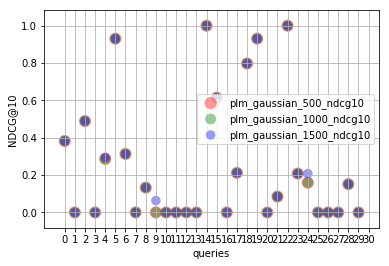

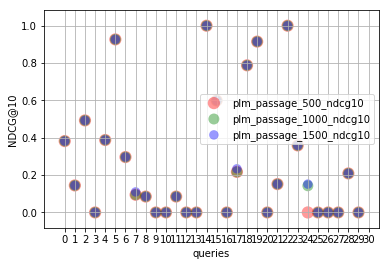

In [30]:
jelinek_mercer_01_ndcg10 = read_statistics('statistics/jelinek_mercer_01_ndcg10.txt')
jelinek_mercer_05_ndcg10 = read_statistics('statistics/jelinek_mercer_05_ndcg10.txt')
jelinek_mercer_09_ndcg10 = read_statistics('statistics/jelinek_mercer_09_ndcg10.txt')   
jelinek_mercer_all_ndcg10 = [jelinek_mercer_01_ndcg10, jelinek_mercer_05_ndcg10, jelinek_mercer_09_ndcg10]

dirichlet_500_ndcg10 = read_statistics('statistics/dirichlet_prior_500_ndcg10.txt')
dirichlet_1000_ndcg10 = read_statistics('statistics/dirichlet_prior_1000_ndcg10.txt')
dirichlet_1500_ndcg10 = read_statistics('statistics/dirichlet_prior_1500_ndcg10.txt')   
dirichlet_all_ndcg10 = [dirichlet_500_ndcg10, dirichlet_1000_ndcg10, dirichlet_1500_ndcg10]  

abs_discount_01_ndcg10 = read_statistics('statistics/absolute_discounting_01_ndcg10.txt')
abs_discount_05_ndcg10 = read_statistics('statistics/absolute_discounting_05_ndcg10.txt')
abs_discount_09_ndcg10 = read_statistics('statistics/absolute_discounting_09_ndcg10.txt')   
abs_discount_all_ndcg10 = [abs_discount_01_ndcg10, abs_discount_05_ndcg10, abs_discount_09_ndcg10]

plm_gaussian_500_ndcg10 = read_statistics('statistics/plm/validation/plm_gaussian_500_ndcg10.txt')
plm_gaussian_1000_ndcg10 = read_statistics('statistics/plm/validation/plm_gaussian_1000_ndcg10.txt')
plm_gaussian_1500_ndcg10 = read_statistics('statistics/plm/validation/plm_gaussian_1500_ndcg10.txt')
plm_gaussian_all_ndcg10 = [plm_gaussian_500_ndcg10, plm_gaussian_1000_ndcg10, plm_gaussian_1500_ndcg10]

plm_passage_500_ndcg10 = read_statistics('statistics/plm/validation/plm_passage_500_ndcg10.txt')
plm_passage_1000_ndcg10 = read_statistics('statistics/plm/validation/plm_passage_1000_ndcg10.txt')
plm_passage_1500_ndcg10 = read_statistics('statistics/plm/validation/plm_passage_1500_ndcg10.txt')
plm_passage_all_ndcg10 = [plm_passage_500_ndcg10, plm_passage_1000_ndcg10, plm_passage_1500_ndcg10]

tfidf_ndcg10 = read_statistics('statistics/tfidf_ndcg10.txt')
BM25_ndcg10 = read_statistics('statistics/bm25_ndcg10.txt')
plm_500_ndcg10 = read_statistics("statistics/plm/validation/plm_passage_500_ndcg10.txt")
    
plot_ndcg_stats(jelinek_mercer_all_ndcg10, labels=['jelinek-mercer_01', 'jelinek-mercer_05', 'jelinek-mercer_09'])
plot_ndcg_stats(dirichlet_all_ndcg10, labels=['dirichlet_500', 'dirichlet_1000', 'abs_discount_1500'])
plot_ndcg_stats(abs_discount_all_ndcg10, labels=['abs_discount_01', 'abs_discount_05', 'abs_discount_09'])
plot_ndcg_stats(plm_gaussian_all_ndcg10, labels=['plm_gaussian_500_ndcg10', 'plm_gaussian_1000_ndcg10', 'plm_gaussian_1500_ndcg10'])
plot_ndcg_stats(plm_passage_all_ndcg10, labels=['plm_passage_500_ndcg10', 'plm_passage_1000_ndcg10', 'plm_passage_1500_ndcg10'])

plt.show()

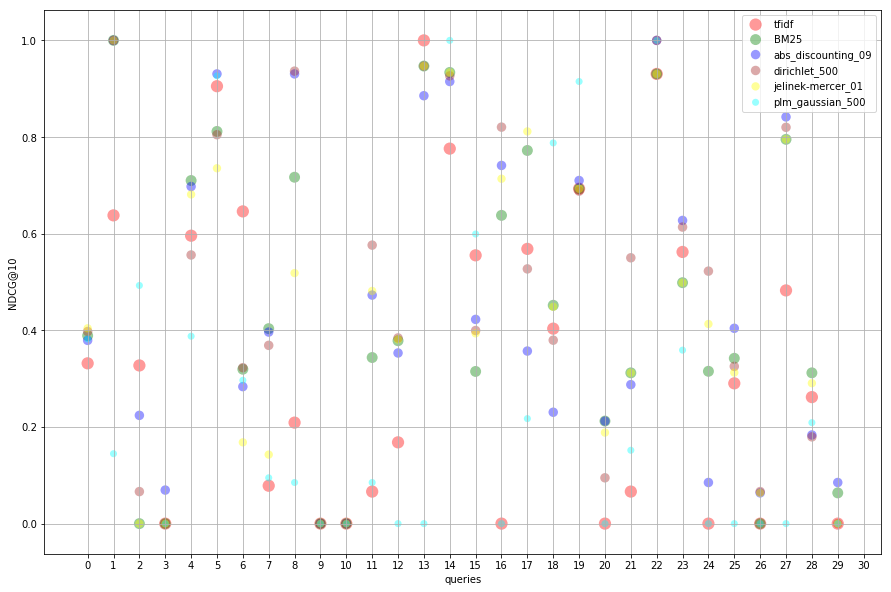

In [31]:
fig_size = [15,10]
plt.rcParams["figure.figsize"] = fig_size

best_comparison = [tfidf_ndcg10,
                   BM25_ndcg10,
                   abs_discount_09_ndcg10,
                   dirichlet_500_ndcg10,
                   jelinek_mercer_01_ndcg10,
                   plm_500_ndcg10]

plot_ndcg_stats(best_comparison, labels=['tfidf', 
                                         'BM25', 
                                         'abs_discounting_09', 
                                         'dirichlet_500', 
                                         'jelinek-mercer_01',
                                         'plm_gaussian_500'])

plt.show()

## Error Analysis

**Query 18: "leveraged buyouts"**

> In this example, the positional language model wins. The words "leveraged" and  "buyouts" occur next to each other very frequently (376 times) and for all bigrams where "buyouts" is the second term, "leveraged" is the first term 54% of the time.

**Query 6: "protect u s farmers"**

> In Query 6, tfidf has the highest ndcg@10 score. A possible explanation is that most  terms in this query have a high frequency in the validation set. Hence, the tfidf model, which does not discount probability mass by smoothing as all the other techniques do, gives an advantage to highly frequent words. It is also worth pointing out that the plm modelis the second highest scoring one, which can be again explained by the same pattern as in query 18 but this time for the tokens "u" and "s".

**Query 16: "commercial overfishing creates food fish deficit"**

> In this example the term "overfishing" occurs very unfrequently and hence we think that that could be the reason that tfidf has the lowest score, because it does not use any smoothing.

**Query 170: "Consequences implantation silicone gel breast devices"** 

> Here, it is quite interesting that plm performs the worst. We are thinking that some subsets of this query occur often within the same passage and therefore documents are retrieved that only contain information relative to this subset.

## Significance testing
- using a two-tailed paired Student t-test
- using a Bonferroni correction to mitigate the multiple comparisons problem

In [32]:
from scipy.stats import ttest_rel

def t_test(metric_comparison_dict, p=0.0125):
    """
    Performs a t-test
    
    :param metric_comparison_dict:
    :param p: significance level based on Bonferroni
    """
    comparisons = list(itertools.combinations(metric_comparison_dict.keys(), 2))
    
    diffs = []
    pvals = []
    
    for metric1, metric2 in comparisons:
        scores1 = metric_comparison_dict[metric1]
        scores2 = metric_comparison_dict[metric2]
        mean_score1 = round(np.mean(scores1),4)
        mean_score2 = round(np.mean(scores2),4)
        p_value = ttest_rel(scores1, scores2)[1]
        t_stat = round(ttest_rel(scores1, scores2)[0],4)
        
        pvals.append(p_value)
        diffs.append(mean_score1-mean_score2)
        
        if p_value < p:
            print("{} vs. {}\nMean diff: {}, t-statistic: {}\nSignificant p-value (p < {}): {}\n"
                  .format(metric1, metric2, round(mean_score1 - mean_score2, 4), t_stat, p, p_value))
        else:
            print("{} vs. {}\nMean diff: {}, t-statistic: {}\nNon-significant p-value (p >= {}): {}\n"
                  .format(metric1, metric2, round(mean_score1 - mean_score2, 4), t_stat, p, p_value))


In [33]:
tfidf_map1000_test = read_statistics('statistics/test/tfidf_map1000_test.txt')
bm25_map1000_test = read_statistics('statistics/test/bm25_map1000_test.txt')
jelinek_mercer_map1000_test = read_statistics('statistics/test/jelinek_mercer_01_map1000_test.txt')
abs_disc_map1000_test = read_statistics('statistics/test/absolute_discounting_09_map1000_test.txt')
dirichlet_map1000_test = read_statistics('statistics/test/dirichlet_prior_500_map1000_test.txt')
plm_passage_map1000_test = read_statistics('statistics/plm/test/plm_passage_1500_map1000_test.txt')

tfidf_ndcg10_test = read_statistics('statistics/test/tfidf_ndcg10_test.txt')
bm25_ndcg10_test = read_statistics('statistics/test/bm25_ndcg10_test.txt')
jelinek_mercer_ndcg10_test = read_statistics('statistics/test/jelinek_mercer_01_ndcg10_test.txt')
abs_disc_ndcg10_test = read_statistics('statistics/test/absolute_discounting_09_ndcg10_test.txt')
dirichlet_ndcg10_test = read_statistics('statistics/test/dirichlet_prior_500_ndcg10_test.txt')
plm_passage_ndcg10_test = read_statistics('statistics/plm/test/plm_passage_1500_ndcg10_test.txt')

tfidf_precision5_test = read_statistics('statistics/test/tfidf_precision5_test.txt')
bm25_precision5_test = read_statistics('statistics/test/bm25_precision5_test.txt')
jelinek_mercer_precision5_test = read_statistics('statistics/test/jelinek_mercer_01_precision5_test.txt')
abs_disc_precision5_test = read_statistics('statistics/test/absolute_discounting_09_precision5_test.txt')
dirichlet_precision5_test = read_statistics('statistics/test/dirichlet_prior_500_precision5_test.txt')
plm_passage_precision5_test = read_statistics('statistics/plm/test/plm_passage_1500_precision5_test.txt')

tfidf_recall1000_test = read_statistics('statistics/test/tfidf_recall1000_test.txt')
bm25_recall1000_test = read_statistics('statistics/test/bm25_recall1000_test.txt')
jelinek_mercer_recall1000_test = read_statistics('statistics/test/jelinek_mercer_01_recall1000_test.txt')
abs_disc_recall1000_test = read_statistics('statistics/test/absolute_discounting_09_recall1000_test.txt')
dirichlet_recall1000_test = read_statistics('statistics/test/dirichlet_prior_500_recall1000_test.txt')
plm_passage_recall1000_test = read_statistics('statistics/plm/test/plm_passage_1500_recall1000_test.txt')


In [34]:
map1000_test_all = {'tfidf_map1000_test': tfidf_map1000_test, 
                    'bm25_map1000_test': bm25_map1000_test, 
                    'jelinek_mercer_map1000_test': jelinek_mercer_map1000_test,
                    'abs_disc_map1000_test': abs_disc_map1000_test,
                    'dirichlet_map1000_test': dirichlet_map1000_test,
                    'plm_passage_map1000_test': plm_passage_map1000_test}

ndcg10_test_all = {'tfidf_ndcg10_test': tfidf_ndcg10_test, 
                    'bm25_ndcg10_test': bm25_ndcg10_test, 
                    'jelinek_mercer_ndcg10_test': jelinek_mercer_ndcg10_test,
                    'abs_disc_ndcg10_test': abs_disc_ndcg10_test,
                    'dirichlet_ndcg10_test': dirichlet_ndcg10_test,
                    'plm_passage_ndcg10_test': plm_passage_ndcg10_test}

precision5_test_all = {'tfidf_precision5_test': tfidf_precision5_test, 
                    'bm25_precision5_test': bm25_precision5_test, 
                    'jelinek_mercer_precision5_test': jelinek_mercer_precision5_test,
                    'abs_disc_precision5_test': abs_disc_precision5_test,
                    'dirichlet_precision5_test': dirichlet_precision5_test,
                    'plm_passage_precision5_test': plm_passage_precision5_test}

recall1000_test_all = {'tfidf_recall1000_test': tfidf_recall1000_test, 
                    'bm25_recall1000_test': bm25_recall1000_test, 
                    'jelinek_mercer_recall1000_test': jelinek_mercer_recall1000_test,
                    'abs_disc_recall1000_test': abs_disc_recall1000_test,
                    'dirichlet_recall1000_test': dirichlet_recall1000_test,
                    'plm_passage_recall1000_test': plm_passage_recall1000_test}

In [35]:
t_test(map1000_test_all)

tfidf_map1000_test vs. bm25_map1000_test
Mean diff: -0.0358, t-statistic: -4.4392
Significant p-value (p < 0.0125): 2.0315894276126578e-05

tfidf_map1000_test vs. jelinek_mercer_map1000_test
Mean diff: -0.0317, t-statistic: -4.2759
Significant p-value (p < 0.0125): 3.863872447555956e-05

tfidf_map1000_test vs. abs_disc_map1000_test
Mean diff: -0.0226, t-statistic: -3.282
Significant p-value (p < 0.0125): 0.001353044958743758

tfidf_map1000_test vs. dirichlet_map1000_test
Mean diff: -0.0328, t-statistic: -4.0682
Significant p-value (p < 0.0125): 8.553430154846259e-05

tfidf_map1000_test vs. plm_passage_map1000_test
Mean diff: 0.1368, t-statistic: 10.476
Significant p-value (p < 0.0125): 1.3562589194801616e-18

bm25_map1000_test vs. jelinek_mercer_map1000_test
Mean diff: 0.0041, t-statistic: 1.6756
Non-significant p-value (p >= 0.0125): 0.0964458498616123

bm25_map1000_test vs. abs_disc_map1000_test
Mean diff: 0.0132, t-statistic: 3.2931
Significant p-value (p < 0.0125): 0.00130491984368

In [36]:
t_test(ndcg10_test_all)

tfidf_ndcg10_test vs. bm25_ndcg10_test
Mean diff: -0.0788, t-statistic: -3.4066
Significant p-value (p < 0.0125): 0.0008977476233348092

tfidf_ndcg10_test vs. jelinek_mercer_ndcg10_test
Mean diff: -0.0721, t-statistic: -3.3904
Significant p-value (p < 0.0125): 0.0009476480488155553

tfidf_ndcg10_test vs. abs_disc_ndcg10_test
Mean diff: -0.0483, t-statistic: -2.1127
Non-significant p-value (p >= 0.0125): 0.036715683064669304

tfidf_ndcg10_test vs. dirichlet_ndcg10_test
Mean diff: -0.0758, t-statistic: -3.2715
Significant p-value (p < 0.0125): 0.0014000523223037275

tfidf_ndcg10_test vs. plm_passage_ndcg10_test
Mean diff: 0.2045, t-statistic: 7.8204
Significant p-value (p < 0.0125): 2.3697874516358687e-12

bm25_ndcg10_test vs. jelinek_mercer_ndcg10_test
Mean diff: 0.0067, t-statistic: 0.8683
Non-significant p-value (p >= 0.0125): 0.3869807268968809

bm25_ndcg10_test vs. abs_disc_ndcg10_test
Mean diff: 0.0305, t-statistic: 2.3881
Non-significant p-value (p >= 0.0125): 0.018507440707763546

In [37]:
t_test(recall1000_test_all)

tfidf_recall1000_test vs. bm25_recall1000_test
Mean diff: 0.0, t-statistic: nan
Non-significant p-value (p >= 0.0125): nan

tfidf_recall1000_test vs. jelinek_mercer_recall1000_test
Mean diff: 0.0, t-statistic: nan
Non-significant p-value (p >= 0.0125): nan

tfidf_recall1000_test vs. abs_disc_recall1000_test
Mean diff: -0.0001, t-statistic: -1.0
Non-significant p-value (p >= 0.0125): 0.3193395975454461

tfidf_recall1000_test vs. dirichlet_recall1000_test
Mean diff: -0.0001, t-statistic: -1.0
Non-significant p-value (p >= 0.0125): 0.31933959754544633

tfidf_recall1000_test vs. plm_passage_recall1000_test
Mean diff: 0.1054, t-statistic: 6.433
Significant p-value (p < 0.0125): 2.727411507314142e-09

bm25_recall1000_test vs. jelinek_mercer_recall1000_test
Mean diff: 0.0, t-statistic: nan
Non-significant p-value (p >= 0.0125): nan

bm25_recall1000_test vs. abs_disc_recall1000_test
Mean diff: -0.0001, t-statistic: -1.0
Non-significant p-value (p >= 0.0125): 0.3193395975454461

bm25_recall1000

In [38]:
t_test(precision5_test_all)

tfidf_precision5_test vs. bm25_precision5_test
Mean diff: -0.07, t-statistic: -2.4762
Non-significant p-value (p >= 0.0125): 0.014686076343882528

tfidf_precision5_test vs. jelinek_mercer_precision5_test
Mean diff: -0.08, t-statistic: -3.0183
Significant p-value (p < 0.0125): 0.0031103262790699105

tfidf_precision5_test vs. abs_disc_precision5_test
Mean diff: -0.0534, t-statistic: -1.9707
Non-significant p-value (p >= 0.0125): 0.05107773453718909

tfidf_precision5_test vs. dirichlet_precision5_test
Mean diff: -0.0667, t-statistic: -2.3205
Non-significant p-value (p >= 0.0125): 0.022018192529847554

tfidf_precision5_test vs. plm_passage_precision5_test
Mean diff: 0.2025, t-statistic: 6.6682
Significant p-value (p < 0.0125): 8.572595810481773e-10

bm25_precision5_test vs. jelinek_mercer_precision5_test
Mean diff: -0.01, t-statistic: -0.8154
Non-significant p-value (p >= 0.0125): 0.41649781275231634

bm25_precision5_test vs. abs_disc_precision5_test
Mean diff: 0.0166, t-statistic: 1.0208


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [ ]:
import operator

import gensim
from gensim import corpora, similarities
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel
from gensim.models.tfidfmodel import TfidfModel

from scipy.stats import entropy as kl_divergence

> First obtain an initial top-1000 ranking for each query using TF-IDF

In [ ]:
def tfidf_filter(n=1000, dataset='validation'):
    """
    Runs a tf-idf retrieval and returns top-n documents.
    
    :param n: the number of documents to retrieve
    :param dataset: 'test' or 'validation
    
    :return dict mapping from queryID to the list of tf-idf top-n documents for that query
    """
    
    data = {}
    
    if dataset == 'test':
        query_to_docs = test_ids
    elif dataset == 'validation':
        query_to_docs = validation_ids
    else:
        raise ValueError("Two possible values for dataset: 'test' or 'validation'.")
    
    
    query_to_top_n = {}
    
    for query_id in query_to_docs.keys():  
        for int_doc_id, _ in query_to_docs[query_id]:  
                
            # discard all zero length docs
            if document_lengths[int_doc_id] == 0:
                continue
                    
            score = 0
            cnt_qwords_in_doc = 0  # num of query words appearing in the doc
 
            # FOR ALL QUERY TERMS
            for q_term in tokenized_queries[query_id]: 
                try: 
                    document_term_freq = inverted_index[q_term][int_doc_id]
                    score += tfidf(int_doc_id, q_term, document_term_freq)
                    cnt_qwords_in_doc += 1

                # query term is not in the document
                except KeyError:
                    document_term_freq = 0
                    score += tfidf(int_doc_id, q_term, document_term_freq)

            # only score documents that contain at least one query term
            if cnt_qwords_in_doc == 0:
                continue

            # Fill data dictionary
            try:
                data[query_id].append((score, int_doc_id))
            except:
                data[query_id] = [(score, int_doc_id)]
                
        scores = [x[0] for x in data[query_id]]
        int_doc_ids = [x[1] for x in data[query_id]]
        
        # reorder list of int_doc_ids based on the ranked scores
        scores, int_doc_ids = zip(*sorted(zip(scores, int_doc_ids), key=operator.itemgetter(0), reverse=True))
        query_to_top_n[query_id] = int_doc_ids[:n]
        
    return query_to_top_n
    

>  and then re-rank the documents using the LSMs

In [ ]:
def run_lsm_retrieval(model_name, model, query_to_top_n, similarity_index=None, dataset='validation'):
    """
    Runs an LSM retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param model: the scoring function
    :param query_to_top_n: dict mapping from queryID to the list of top-n documents for that query
    :param similarity_index: necessary for the LSI model (see gensim.similarities)
    :param dataset: 'test' or 'validation
    """
    model_name = model_name.upper()
    
    if model_name[:3] == 'LSI':
        use_lsi = True
        if not similarity_index:
            raise ValueError("Similarity index must be provided for LSI retrieval.")         
    elif model_name[:3] == 'LDA':
        use_lsi = False
    else:
        raise ValueError("Two available models: 'LSI' or 'LDA'.")
        
    run_out_path = '{}.run'.format(model_name.lower())
    if os.path.exists(run_out_path):
        print("This output file ({}) already exists.\n".format(run_out_path),
              "Delete this file, rename it, or move it elsewhere in your file system.\n", sep='')
        return
    
    if dataset == 'test':
        query_to_docs = test_ids
    elif dataset == 'validation':
        query_to_docs = validation_ids
    else:
        raise ValueError("Two possible values for dataset: 'test' or 'validation'.")
    
    
    print('Retrieval model: {}'.format(model_name))
    
    # Fill the data dictionary. 
    # The dictionary data has the form: query_id --> (document_score, external_doc_id)
    data = {}
    
    # FOR ALL QUERIES
    for query_id in query_to_docs.keys():
        # 1. represent query as a BOW
        query_counter = collections.Counter(token_id 
                                            for token_id in token_ids
                                            if token_id > 0
                                           )
        query_terms = list(query_counter.items())
        
        # 2. apply tf-idf model to query
        query_tfidf = tfidf_model[query_terms]
        
        # 3. obtain query vector using LSI or LDA
        query_vec = model[query_tfidf]
        
        if use_lsi:
            # get cosine similarities with all docs
            similarities = similarity_index[query_vec]
        else:
            # get probability distribution over topics
            query_distribution = [x[1] for x in query_vec]
        
        for int_doc_id in query_to_top_n[query_id]:
            if use_lsi:
                # score with cosine
                score = similarities[int_doc_id - 1]
            else:
                # get probability distribution over topics for the document
                doc_tfidf = tfidf_corpus[int_doc_id - 1]
                doc_distribution = [x[1] for x in model[doc_tfidf]]
                # score using Kullback-Leibler divergence
                score = - kl_divergence(query_distribution, doc_distribution)
            
            ext_doc_id, _ = index.document(int_doc_id)
            
            # Fill data dictionary
            try:
                data[query_id].append((score, ext_doc_id))
            except:
                data[query_id] = [(score, ext_doc_id)]
    
    # Write output to TREC .run file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)


In [ ]:
# Actually run the tf-idf filtering
query_to_top1000_validation = tfidf_filter(n=1000, dataset='validation')
query_to_top1000_test = tfidf_filter(n=1000, dataset='test')

### Corpus preprocessing

In [ ]:
_, id2token, _ = index.get_dictionary()

In [ ]:
def corpus_to_bow():
    """
    Transform corpus from raw text to a bag-of-words representation.
    """
    corpus = []

    for int_doc_id in range(index.document_base(), index.maximum_document()):
        _, token_ids = index.document(int_doc_id)

        text_bow = collections.Counter(token_id 
                                       for token_id in token_ids
                                       if token_id > 0)
        corpus.append(text_bow)
        
    return corpus

> First, convert the corpus to a BOW representation.

In [ ]:
corpus_bow = [list(counter.items()) for counter in corpus_to_bow()]

> Then, apply a tf-idf model to the corpus.

In [ ]:
tfidf_model = TfidfModel(corpus_bow)

In [ ]:
tfidf_corpus = [x for x in tfidf_model[corpus_bow]]

### LSI: parameter optimization
#### Number of topics

In [ ]:
lsi_models_numtopics = {}
lsi_similarity_indices_numtopics = {}

for num_topics in [3, 10, 15, 20, 40, 70, 100, 200, 300, 400]:
    iter_start_time = time.time()

    lsi = LsiModel(tfidf_corpus,
                   id2word=id2token,
                   num_topics=num_topics,
                   chunksize=20000,
                   onepass=True,
                   power_iters=2)

    lsi_models_numtopics[num_topics] = lsi
    lsi_similarity_indices_numtopics[num_topics] = similarities.MatrixSimilarity(
                                                                lsi[tfidf_corpus],
                                                                num_features=num_topics
                                                            )
    print('Number of topics: {}.  {} seconds'.format(num_topics, int(time.time() - iter_start_time)))

In [ ]:
for param_setting, lsi_model in lsi_models_numtopics.items():
    run_lsm_retrieval(model_name='lsi_numtopics_{}'.format(param_setting),
                          model=lsi_model,
                          similarity_index=lsi_similarity_indices_numtopics[param_setting],
                          query_to_top_n=query_to_top1000,
                          dataset='validation')

lsi_models_numtopics = None
lsi_similarity_indices_numtopics = None

#### Chunk size

In [ ]:
lsi_models_chunksize = {}
lsi_similarity_indices_chunksize = {}

for chunksize in [5000, 10000, 20000, 30000]:
    print('Chunksize: {}'.format(chunksize))
    iter_start_time = time.time()

    lsi = LsiModel(tfidf_corpus,
                   id2word=id2token,
                   num_topics=200,
                   chunksize=chunksize,
                   onepass=True,
                   power_iters=2)

    lsi_models_chunksize[chunksize] = lsi
    lsi_similarity_indices_chunksize[chunksize] = similarities.MatrixSimilarity(lsi[tfidf_corpus],
                                                                                num_features=200)
    print('Runtime: {} seconds'.format(int(time.time() - iter_start_time)))

In [ ]:
for param_setting, lsi_model in lsi_models_chunksize.items():
    run_lsm_retrieval(model_name='lsi_chunksize_{}'.format(param_setting),
                          model=lsi_model,
                          similarity_index=lsi_similarity_indices_chunksize[param_setting],
                          query_to_top_n=query_to_top1000,
                          dataset='validation')
    
lsi_models_chunksize = None
lsi_similarity_indices_chunksize = None

#### One-pass or multi-pass stochastic algorithm

In [ ]:
lsi_models_onepass = {}
lsi_similarity_indices_onepass = {}

for onepass in [False, True]:
    if onepass:
        print('One-pass')
    else:
        print('Multi-pass')
    iter_start_time = time.time()

    lsi = LsiModel(tfidf_corpus,
                   id2word=id2token,
                   num_topics=200,
                   chunksize=20000,
                   onepass=onepass,
                   power_iters=2)

    lsi_models_onepass[onepass] = lsi
    lsi_similarity_indices_onepass[onepass] = similarities.MatrixSimilarity(
                                                                lsi[tfidf_corpus],
                                                                num_features=200
                                                            )
    print('Runtime: {} seconds'.format(int(time.time() - iter_start_time)))

In [ ]:
for param_setting, lsi_model in lsi_models_onepass.items():
    run_lsm_retrieval(model_name='lsi_onepass_{}'.format(param_setting),
                          model=lsi_model,
                          similarity_index=lsi_similarity_indices_onepass[param_setting],
                          query_to_top_n=query_to_top1000,
                          dataset='validation')
    
lsi_models_onepass = None
lsi_similarity_indices_onepass = None

### LDA: parameter optimization
#### Number of topics

In [ ]:
lda_models_numtopics = {}

for num_topics in [40, 70, 100, 130, 160]:
    print('Number of topics: {}'.format(num_topics))
    iter_start_time = time.time()

    lda = LdaModel(tfidf_corpus,
                   num_topics=num_topics,
                   chunksize=2000,
                   alpha='auto',
                   eta='auto',
                   minimum_probability=0.0,
                   per_word_topics=False)

    lda_models_numtopics[num_topics] = lda

    print('Runtime: {} seconds'.format(int(time.time() - iter_start_time)))

In [ ]:
for param_setting, lda_model in lda_models_numtopics.items():
    run_lsm_retrieval(model_name='lda_numtopics_{}'.format(param_setting),
                          model=lda_model,
                          query_to_top_n=query_to_top1000,
                          dataset='validation')
    
lda_models_numtopics = None

#### Chunk size

In [ ]:
lda_models_chunksize = {}

for chunksize in [500, 2000, 10000]:
    print('Chunksize: {}'.format(chunksize))
    iter_start_time = time.time()

    lda = LdaModel(tfidf_corpus,
                   num_topics=100,
                   chunksize=chunksize,
                   alpha='auto',
                   eta='auto',
                   minimum_probability=0.0,
                   per_word_topics=False)

    lda_models_chunksize[chunksize] = lda

    print('Runtime: {} seconds'.format(int(time.time() - iter_start_time)))

In [ ]:
for param_setting, lda_model in lda_models_chunksize.items():
    run_lsm_retrieval(model_name='lda_chunksize_{}'.format(param_setting),
                          model=lda_model,
                          query_to_top_n=query_to_top1000,
                          dataset='validation')
    
lda_models_chunksize = None

> All hyperparameters are now set. Please read the report for further details.

### Latent Semantic Indexing

In [ ]:
lsi = LsiModel(tfidf_corpus,
               id2word=id2token,
               num_topics=20,
               chunksize=5000,
               onepass=True,
               power_iters=2)

lsi_similarity_index = similarities.MatrixSimilarity(lsi[tfidf_corpus], num_features=20)

run_lsm_retrieval(model_name='LSI',
                  model=lsi,
                  similarity_index=lsi_similarity_index,
                  query_to_top_n=query_to_top1000_test,
                  dataset='test')

lsi.save('lsi_model')
lsi_similarity_index.save('lsi_similarity_index')

### Latent Dirichlet Allocation

In [ ]:
lda = LdaModel(tfidf_corpus,
               num_topics=100,
               chunksize=2000,
               alpha='auto',
               eta='auto',
               minimum_probability=0.0,
               per_word_topics=False)

run_lsm_retrieval(model_name='LDA',
                  model=lda,
                  query_to_top_n=query_to_top1000_test,
                  dataset='test')

lda = LdaModel.save('./lda_model')

### Significance testing: LSI vs. LDA

In [ ]:
lsi_ndcg10_test = read_statistics('statistics/test/lsi_ndcg10_test.txt')
lda_ndcg10_test = read_statistics('statistics/test/lda_ndcg10_test.txt')
ndcg10_test_all = {'lsi_ndcg10_test': lsi_ndcg10_test, 'lda_ndcg10_test': lda_ndcg10_test}

lsi_map1000_test = read_statistics('statistics/test/lsi_map1000_test.txt')
lda_map1000_test = read_statistics('statistics/test/lda_map1000_test.txt')
map1000_test_all = {'lsi_map1000_test': lsi_map1000_test, 'lda_map1000_test': lda_map1000_test}

lsi_recall1000_test = read_statistics('statistics/test/lsi_recall1000_test.txt')
lda_recall1000_test = read_statistics('statistics/test/lda_recall1000_test.txt')
recall1000_test_all = {'lsi_recall1000_test': lsi_recall1000_test, 'lda_recall1000_test': lda_recall1000_test}

lsi_precision5_test = read_statistics('statistics/test/lsi_precision5_test.txt')
lda_precision5_test = read_statistics('statistics/test/lda_precision5_test.txt')
precision5_test_all = {'lsi_precision5_test': lsi_precision5_test, 'lda_precision5_test': lda_precision5_test}

In [ ]:
t_test(ndcg10_test_all)
t_test(map1000_test_all)
t_test(recall1000_test_all)
t_test(precision5_test_all)

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

#### Train a Skip-gram model

In [ ]:
def train_w2v():
    """
    Get w2v for all terms
    """
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    word2vec_init = gensim.models.Word2Vec(
        size= 300,    # Embedding size
        window=5,     # One-sided window size
        sg=True,      # Skip-gram
        min_count=5,  # Minimum word frequency
        sample=1e-3,  # Sub-sample threshold
        hs=False,     # Hierarchical softmax
        negative=10,  # Number of negative examples
        iter=1,       # Number of iterations
        workers=8,    # Number of workers
    )

    word2vec_init.build_vocab(sentences, trim_rule=None)

    print("start training")

    model = word2vec_init
    model.train(sentences, total_examples = len(sentences) , epochs= 5 )
    model.wv.save_word2vec_format('model_w2v.bin')
    model.wv.save_word2vec_format('model_w2v.txt', binary=False)

#### Or load pre-trained word2vec embeddings

In [ ]:
# Read google embeddings

with open("reduced_vectors_google.txt","r") as f:
    g_embeds = {}
    vec = []

    for i, l in enumerate(f):
        if i == 0:
            continue

        line = l.split()
        vec.extend(line)
        if len(vec) == 301:
            g_embeds[vec[0]] = [float(entry) for entry in vec[1:]]
            vec = []

> for covenience... 

In [ ]:
def IDF_all_terms(term_id):
    """
    Inverse Document Frequency of a term.
    
    :param term_id : the term id 
    """
    df = term2numdocs[term_id]

    return log(num_documents / df) 

In [ ]:
# Top 1000 docs for each query in the test set.
tfidf_filter_test = tfidf_filter(n=1000, dataset='test')

### Combining word embeddings
- weighting words by their tf-idf (documents)
- weighting words by their BM25 score (documents)
- averaging over words (queries)

[please see the report for a more detailed description]

In [ ]:
def word2doc_subset(subset, embeds, weight_model = "tfidf"):
    """
    Creates dictionary of document embeddings, "int_doc_id" --> np_array of doc embed.
    
    :param subset: a subset of the data, for example top1000 by tfidf
    :param embeds: either self trained by w2w or google embeds
    :param weight_model : either "tfidf" or "BM25"
    """
    except_list = []
    key_error = 0
    doc_embeds = dict()
    count = 0
    count_words_below_5 = 0

     # FOR ALL QUERIES
    for query_id in list(subset.keys()):  
        # FOR ALL DOCUMENTS
        for int_doc_id in subset[query_id]:  

            # discard all zero length docs
            if document_lengths[int_doc_id] == 0:
                continue

            _ , doc_token_ids = index.document(int_doc_id)

            document_bow = collections.Counter(
            token_id for token_id in doc_token_ids
            if token_id > 0)
        
            document_vec = np.zeros(300)
            normalization_const = 0
            for token_id in document_bow.keys():
                # only if the term is in the w2v embeddings (i.e. it appears more than 5 times in collection)
                try:
                    # log normalized tf
                    tf = 1 + log(document_bow[token_id])
                    idf = IDF_all_terms(token_id)
                    if weight_model == "tfidf":
                        
                        weight = tf * idf
                        
                    elif weight_model == "BM25":
                        
                        doc_len = sum(document_bow.values())
                        
                        weight = (2.2*tf)/(1.2*(0.25+0.75*(doc_len/avg_doc_length)) + tf) * idf
                
                    # weight * word2vec embed of term
                   
                    document_vec += weight * np.array(embeds[id2token[token_id]])
                    
                    normalization_const += 1
                except KeyError:
                    if token_id not in except_list:
                        except_list.append(token_id)
                    key_error +=1
                    continue
                
            # only create document embedding if there was at least a term present in the w2v embeddings
            if normalization_const != 0:
                doc_embeds[int_doc_id] = document_vec / normalization_const

    return doc_embeds                
                    

def word2query_subset(subset, embeds):
    """
    Creates dictionary of query embeddings, "query_id" --> np_array of query embed.

    :param subset: a subset of the data, for example top1000 by tfidf
    :param embeds: either self trained with word2vec or Google embeds
    """
    query_embeds = dict()
    
    for query_id in list(subset.keys()):  
        query_term_embeds = np.zeros(300)
        query_len = 0
        for q_term in tokenized_queries[query_id]:
            
            try:
                query_len += 1
                query_term_embeds += np.array(embeds[id2token[q_term]])
                
            except KeyError:
                continue
            
        if query_len > 0:
        
            query_avg = query_term_embeds/query_len
        
        query_embeds[query_id] = query_avg
       
    return query_embeds

In [ ]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('model_w2v.txt', binary=False) 

In [ ]:
# doc and query embeds of test set 
doc_embeds = word2doc_subset(tfidf_filter_test, model)
doc_embeds_g = word2doc_subset(tfidf_filter_test, g_embeds)

query_embeds = word2query_subset(tfidf_filter_test, model)
query_embeds_g = word2query_subset(tfidf_filter_test, g_embeds)

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

### Document embeddings
- 300-dimensional: __query_vector + document_vector__
- 600-dimensional: __query_vector ; document_vector__

In [ ]:
def load_distributional_data(split, doc_embeds, query_embeds):
    '''
    Load query-document distributional features.
    
    :param split: 'test' or 'validation'
    :param doc_embeds: a dict mapping from internal document ids to document embeddings
    :param query_embeds: a dict mapping from query ids to query embeddings
    
    :return X_concat, X_add, y, query_doc_pairs
    
            X_concat: numpy array of features consisting of the concatenated doc and query embeddings
            X_add: numpy array of features consisting of the addition of a doc and a query embedding
            y: numpy array of binary relevance labels
            query_doc_pairs: list of query-doc pairs with indices corresponding to the list of features
    '''
    
    if split != 'test' and split != 'validation':
        raise ValueError("Only values for split: 'test', 'validation'.")
        
    X_concat = []
    X_add = []
    query_doc_pairs = []
    
    query_to_docs = test_ids if split == 'test' else validation_ids

    for query_id in query_to_docs.keys():
        query_embed = query_embeds[query_id]
        
        for int_doc_id, ext_doc_id in query_to_docs[query_id]: 
            # discard all zero length docs
            if document_lengths[int_doc_id] == 0:
                continue
            
            try:
                doc_embed = doc_embeds[int_doc_id]
            except KeyError:
                continue  # document is not in the top 1000
            
            feature_vec_concat = np.concatenate([query_embed, doc_embed])
            feature_vec_add = query_embed + doc_embed
            
            X_concat.append(feature_vec_concat)
            X_add.append(feature_vec_add)
            
            query_doc_pairs.append((query_id, ext_doc_id))
            
            
    y = np.zeros(len(X_concat))

    path = './ap_88_89/qrel_test' if split == 'test' else './ap_88_89/qrel_validation'
    with open(path, 'r') as f:
        for line in f:
            line = line.strip().split()
            q_id = line[0]
            doc_id = line[2]
            label = line[3]

            try:
                idx = query_doc_pairs.index((q_id, doc_id))
                y[idx] = int(label)
            except ValueError:
                continue

    return np.array(X_concat), np.array(X_add), y, query_doc_pairs

In [ ]:
### Alternative: Combine all methods into a feature vector consisting of 8 scores

In [ ]:
lsi = LsiModel.load('./lsi_model')
lsi_similarity_index = similarities.MatrixSimilarity.load('./lsi_similarity_index')
lda = LdaModel.load('./lda_model/lda_model')

In [ ]:
def load_data(split):
    '''
    Load query-document features.
    A feature consists of an 8-dimensional vector containing scores obtained with the following methods:
    tfidf, BM25, Jelinek-Mercer, Dirichlet prior, Absolute Discounting, LSI, LDA, PLM.
    
    :param split: 'test' or 'validation'
    
    :return X, y, query_doc_pairs
    
            X: numpy feature matrix
            y: numpy array of binary relevance labels
            query_doc_pairs: list of query-doc pairs with indices corresponding to the list of
                             features and that of labels
    '''
    if split != 'test' and split != 'validation':
        raise ValueError("Only values for split: 'test', 'validation'.")

    X = []
    query_doc_pairs = []

    query_to_docs = test_ids if split == 'test' else validation_ids

    for query_id in query_to_docs.keys():
        query_counter = collections.Counter(token_id 
                                            for token_id in tokenized_queries[query_id]
                                            if token_id > 0
                                            )
        query_terms = list(query_counter.items())
        query_tfidf = tfidf_model[query_terms]
        query_vec_lsi = lsi[query_tfidf]
        query_vec_lda = None

        similarities = lsi_similarity_index[query_vec_lsi]

        for int_doc_id, ext_doc_id in query_to_docs[query_id]: 

            # discard all zero length docs
            if document_lengths[int_doc_id] == 0:
                continue

            feature_vec = []

            for score_fn in [tfidf, BM25, jelinek_mercer, dirichlet_prior, absolute_discounting, lsi, lda]:

                cnt_qwords_in_doc = 0  # how many query words occ
                score = 0

                if score_fn == lsi:
                    score = similarities[int_doc_id - 1]
                if score_fn == lda:
                    if query_vec_lda is None:
                        query_vec_lda = lda[query_tfidf]
                        query_distribution = [x[1] for x in query_vec_lda]

                    doc_tfidf = tfidf_corpus[int_doc_id - 1]
                    doc_distribution = [x[1] for x in lda[doc_tfidf]]
                    score = - kl_divergence(query_distribution, doc_distribution)

                for q_term in tokenized_queries[query_id]: 

                    try: 
                        document_term_freq = inverted_index[q_term][int_doc_id]
                        cnt_qwords_in_doc += 1
                    except KeyError:
                        document_term_freq = 0  # query term is not in the document

                    if score_fn == tfidf or score_fn == BM25:
                        score += score_fn(int_doc_id, q_term, document_term_freq)
                    elif score_fn == jelinek_mercer:
                        score += log(score_fn(int_doc_id, q_term, document_term_freq, **{'lambda':0.1}))
                    elif score_fn == dirichlet_prior:
                        score += log(score_fn(int_doc_id, q_term, document_term_freq, mu=500))
                    elif score_fn == absolute_discounting:
                        score += log(score_fn(int_doc_id, q_term, document_term_freq, delta=0.9))

                # transform back from log-probs to probs
                if score_fn in [jelinek_mercer, dirichlet_prior, absolute_discounting]:
                    score = exp(score)

                # only score documents that contain at least one query term
                if cnt_qwords_in_doc == 0:
                    score = 0

                # append score for this scoring function to
                feature_vec.append(score)

            X.append(feature_vec)
            query_doc_pairs.append((query_id, ext_doc_id))

    y = np.zeros(len(X))

    path = './ap_88_89/qrel_test' if split == 'test' else './ap_88_89/qrel_validation'
    with open(path, 'r') as f:
        for line in f:
            line = line.strip().split()
            q_id = line[0]
            doc_id = line[2]
            label = line[3]

            try:
                idx = query_doc_pairs.index((q_id, doc_id))
                y[idx] = int(label)
            except ValueError:
                continue

    return np.array(X), y, query_doc_pairs

> Now, generate a new test set based on 30 queries uniformly sampled from the joint validation and test sets.

In [ ]:
np.random.seed(0)

ids = [103, 111, 114, 120, 123, 135, 143, 144, 151, 155, 158, 165, 167, 170, 173,
       180, 182, 192, 53, 57, 69, 74, 78, 86, 89, 90, 92, 93, 94, 95, 83, 84, 85,
       102, 104, 105, 106, 107, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119,
       121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137,
       138, 139, 140, 141, 142, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156,
       157, 159, 160, 161, 162, 163, 164, 166, 168, 169, 171, 172, 174, 175, 176,
       177, 178, 179, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194,
       195, 196, 197, 198, 199, 200, 51, 52, 54, 55, 56, 58, 59, 60, 100, 61, 62, 
       63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 79, 80, 82, 101, 87, 
       88, 91, 96, 97, 98, 99, 81]

ids = np.array(ids)
np.random.shuffle(ids)
random_query_ids = np.random.choice(ids, 30)

out_f = open('ap_88_89/qrel_final_test', 'w')

# The usual queryID -> (int_doc_id, ext_doc_id) dictionary
final_test_ids = {}

with open('ap_88_89/qrel_test', 'r') as f:
    for l in f:
        line = l.strip().split()
        if len(line) != 4:
            continue

        q_id = line[0]
        ext_id = line[2]

        if int(q_id) not in random_query_ids:
            continue

        print(l, file=out_f, end='')

        try:
            int_id = ext_to_int[ext_id]

            try:
                final_test_ids[q_id].append((int_id, ext_id))
            except KeyError:
                final_test_ids[q_id] = [(int_id, ext_id)]

        except KeyError:
            pass  # test document not in index

with open('ap_88_89/qrel_validation', 'r') as f:
    for l in f:
        line = l.strip().split()
        if len(line) != 4:
            continue

        q_id = line[0]
        ext_id = line[2]

        if int(q_id) not in random_query_ids:
            continue

        print(l, file=out_f, end='')

        try:
            int_id = ext_to_int[ext_id]

            try:
                final_test_ids[q_id].append((int_id, ext_id))
            except KeyError:
                final_test_ids[q_id] = [(int_id, ext_id)]

        except KeyError:
            pass  # test document not in index

out_f.close()

> Load feature matrix and relevance labels.

In [ ]:
# Load query-document embeddings and relevance labels

# word2vec embeddings trained on document collection
# Pre-trained word2vec embeddings. Construct the training and test datasets
Xe_concat, Xe_add, ye, query_e_doc_pairs = load_distributional_data('test', doc_embeds_g, query_embeds_g)
Xe_concat_test, Xe_add_test, ye_test, query_e_doc_pairs_test = load_distributional_data('validation',
                                                                                        doc_embeds_g_validation,
                                                                                        query_embeds_g_validation)

np.savetxt("Xe_concat.csv", Xe_concat, delimiter=',')
np.savetxt("Xe_add.csv", Xe_add, delimiter=',')
np.savetxt('ye.csv', ye, delimiter=',')
np.savetxt('Xe_concat_test.csv', Xe_concat_test, delimiter=',')
np.savetxt("Xe_add_test.csv", Xe_add_test, delimiter=',')
np.savetxt('ye_test.csv', ye_test, delimiter=',')

with open('query_e_doc_pairs', 'wb') as f:
    pickle.dump(query_e_doc_pairs, f)

with open('query_e_doc_pairs_test', 'wb') as f:
    pickle.dump(query_e_doc_pairs_test, f)


# Construct the training and test datasets with features
X, y, query_doc_pairs = load_data('test')
X_test, y_test, query_doc_pairs_test = load_data('validation')

np.savetxt("X.csv", X, delimiter=',')
np.savetxt('y.csv', y, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

with open('query_doc_pairs', 'wb') as f:
    pickle.dump(query_doc_pairs, f)

with open('query_doc_pairs_test', 'wb') as f:
    pickle.dump(query_doc_pairs_test, f)

# Load training, testing datasets
Xe_concat = np.loadtxt(open('Xe_concat.csv', 'rb'), delimiter=',')
Xe_add = np.loadtxt(open('Xe_add.csv', 'rb'), delimiter=',')
ye = np.loadtxt(open('ye.csv', 'rb'), delimiter=',')
Xe_concat_test = np.loadtxt(open('Xe_concat_test.csv', 'rb'), delimiter=',')
Xe_add_test = np.loadtxt(open('Xe_add_test.csv', 'rb'), delimiter=',')
ye_test = np.loadtxt(open('ye_test.csv', 'rb'), delimiter=',')

with open('query_e_doc_pairs', 'rb') as f:
    query_e_doc_pairs = pickle.load(f)

with open('query_e_doc_pairs_test', 'rb') as f:
    query_e_doc_pairs_test = pickle.load(f)


X = np.loadtxt(open('X.csv', 'rb'), delimiter=',')
y = np.loadtxt(open('y.csv', 'rb'), delimiter=',')
X_test = np.loadtxt(open('X_test.csv', 'rb'), delimiter=',')
y_test = np.loadtxt(open('y_test.csv', 'rb'), delimiter=',')

with open('query_doc_pairs', 'rb') as f:
    query_doc_pairs = pickle.load(f)

with open('query_doc_pairs_test', 'rb') as f:
    query_doc_pairs_test = pickle.load(f)

## Pointwise learning: Logistic Regression
- trained using 10-fold cross validation on the test set.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logreg_crossval = LogisticRegressionCV(Cs=10,
                                       fit_intercept=True,
                                       cv=10, 
                                       dual=False,
                                       penalty='l2', 
                                       scoring=None,
                                       solver='lbfgs',
                                       tol=0.0001,
                                       max_iter=100, 
                                       class_weight=None,
                                       intercept_scaling=1.0,
                                       multi_class='ovr',
                                       random_state=None)

logreg = logreg_crossval.fit(X, y)

In [ ]:
def run_logreg_retrieval(model_name, predictions, query_doc_pairs, dataset='validation'):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: ranknet or logreg
    :param predictions: predictions [0, 1] made by the model
    :param query_doc_pairs: list of (query_id, ext_doc_id)
    :param dataset: validation/test dataset used

    """
    run_out_path = '{}.run'.format(model_name)
    
    if model_name.startswith('ranknet'):
        run_out_path = 'runs/ranknet/{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        print("This output file ({}) already exists.\n".format(run_out_path),
              "Delete this file, rename it, or move it elsewhere in your file system.\n", sep='')
        return
    
    if dataset == 'test':
        query_to_docs = test_ids
    elif dataset == 'validation':
        query_to_docs = validation_ids
    else:
        raise ValueError("Two possible values for dataset: 'test' or 'validation'.")
    
    data = {}
    
    # FOR ALL QUERIES
    for query_id in query_to_docs.keys():  
        # FOR ALL DOCUMENTS
        for int_doc_id, ext_doc_id in query_to_docs[query_id]:
            try:
                idx = query_doc_pairs.index((str(query_id), ext_doc_id))
            except:
                continue
            
            if model_name == 'logreg':
                p_zero, p_one = predictions[idx]
            elif model_name.startswith('ranknet'):
                p_one = predictions[idx]

            # Fill data dictionary
            try:
                data[query_id].append((p_one, ext_doc_id))
            except:
                data[query_id] = [(p_one, ext_doc_id)]
    
    # Write output to TREC .run file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)  # only consider top 1000 docs for each query

In [ ]:
logreg_preds = logreg.predict_proba(X)

# Logreg on the constructed features
run_logreg_retrieval('logreg', logreg_preds, query_doc_pairs_test, dataset='test')

## Pairwise: RankNet

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L
import six

from chainer import optimizers
from chainer import serializers
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
class NN(object):
    """
    Defines a Neural Netwok object
    """
    def init(self, Model, train_X, n_units1, n_units2):
        self.model = Model(len(train_X[0]), n_units1, n_units2, 1)
        self.optimizer = optimizers.Adam()
        self.optimizer.setup(self.model)

    def split_data(self, fit_X, fit_y, tv_ratio):
        '''
        Split data into training and validation sets
        
        :param fit_X: features (input)
        :param fit_y: output
        :param tv_ratio: training to validation ratio
        '''
        N_train = int(np.floor(len(fit_X) * tv_ratio))
        train_X, validate_X = np.split(np.asarray(fit_X).astype(np.float32), [N_train])
        train_y, validate_y = np.split(np.asarray(fit_y).astype(np.float32).reshape(len(fit_y), 1), [N_train])
        return train_X, train_y, validate_X, validate_y

    def predict(self, predict_X):
        return self.model.predict(predict_X.astype(np.float32))

In [ ]:
class Model(chainer.Chain):
    """
    RankNet - Pairwise comparison of ranking.
    """
    def __init__(self, n_in, n_units1, n_units2, n_out):
        super(Model, self).__init__(l1=L.Linear(n_in, n_units1),
                                    l2=L.Linear(n_units1, n_units2),
                                    l3=L.Linear(n_units2, n_out),)

    def __call__(self, x_i, x_j, t_i, t_j):

        s_i = self.l3(F.relu(self.l2(F.relu(self.l1(x_i)))))
        s_j = self.l3(F.relu(self.l2(F.relu(self.l1(x_j)))))
        s_diff = s_i - s_j

        if t_i.data > t_j.data:
            S_ij = 1
        elif t_i.data < t_j.data:
            S_ij = -1
        else:
            S_ij = 0

        self.loss = (1 - S_ij) * s_diff / 2. + F.log(1 + F.exp(-s_diff))
        return self.loss

    def predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h = F.relu(self.l3(h2))

        return h.data


class RankNet(NN):
    """
    RankNet training function.
    """
    def __init__(self, model=None):
        self.model = model
        self.train_loss, self.test_loss = [], []

    def ndcg(self, y_true, y_score, k=100):
        '''
        Evaluation function of NDCG@100
        '''
        y_true = y_true.ravel()
        y_score = y_score.ravel()
        y_true_sorted = sorted(y_true, reverse=True)
        ideal_dcg = 0
        for i in range(k):
            ideal_dcg += (2 ** y_true_sorted[i] - 1.) / np.log2(i + 2)
        dcg = 0
        argsort_indices = np.argsort(y_score)[::-1]
        for i in range(k):
            dcg += (2 ** y_true[argsort_indices[i]] - 1.) / np.log2(i + 2)
        ndcg = dcg / ideal_dcg

        return ndcg

    def train_model(self, x_train, y_train, x_test, y_test, n_iter):
        '''
        Training function
        '''
        sigma = 5.0
        loss_step = 100

        for step in tqdm(range(n_iter)):
            i, j = np.random.randint(len(x_train), size=2)
            x_i = chainer.Variable(x_train[i].reshape(1, -1))
            x_j = chainer.Variable(x_train[j].reshape(1, -1))
            y_i = chainer.Variable(y_train[i])
            y_j = chainer.Variable(y_train[j])
            self.optimizer.update(self.model, x_i, x_j, y_i, y_j)

            if (step + 1) % loss_step == 0:
                train_score = self.model.predict(chainer.Variable(x_train))
                test_score = self.model.predict(chainer.Variable(x_test))
                train_ndcg = self.ndcg(y_train, train_score)
                test_ndcg = self.ndcg(y_test, test_score)
                self.train_loss.append(train_ndcg)
                self.test_loss.append(test_ndcg)

    def fit(self, fit_X, fit_y, batchsize=100, n_iter=5000, n_units1=512, n_units2=128, tv_ratio=0.95):

        train_X, train_y, validate_X, validate_y = self.split_data(fit_X, fit_y, tv_ratio)
        self.init(Model, train_X, n_units1, n_units2)
        self.train_model(train_X, train_y, validate_X, validate_y, n_iter)

In [ ]:
def run_ranknet(X_train, y_train, X_test, y_test, name, iterations=1000):
    """
    Train and test RankNet

    :param X_train: training data (input)
    :param y_train: training data (output)
    :param X_test: testing data (input)
    :param y_test: testing data (output)
    :param name: name of the model
    :param iterations: number of iterations during training
    """
    ranknet = RankNet()
    ranknet.fit(X_train, y_train, n_iter=iterations)

    y_pred = ranknet.predict(X_test)
    y_pred_list = y_pred.tolist()

    run_logreg_retrieval(name, y_pred.flatten(), query_e_doc_pairs_test, dataset='validation')

In [ ]:
# RankNet on the constructed features
run_ranknet(X, y, X_test, y_test, name='ranknet_constructed_1000', iterations=1000)

# RankNet on the word embeddings as features (concatenated)
run_ranknet(Xe_concat, ye, Xe_concat_test, ye_test, name='ranknet_e_concat_1000', iterations=1000)

# RankNet on the word embeddings as features (add)
run_ranknet(Xe_add, ye, Xe_add_test, ye_test, name='ranknet_e_add_1000', iterations=1000)

### Task 5: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
